# New structure dataset
This notebook changes the folder structure for out dataset, we also choose to balance the dataset. It is now very imbalanced.

<br><br><br>
# Libaries

In [193]:
# General libaries
import os, shutil
import pandas as pd
import numpy as np
import pickle
import copy

pd.set_option('max_colwidth', -1)
pd.set_option("display.max_rows", 100)

C:\Users\Paulo\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


<br><br><br>
# Global variables

In [135]:
original_dataset_path = os.path.join(os.getcwd(), 'datasets', 'UTKface_inthewild')
new_directory = os.path.join(os.getcwd(), 'datasets', 'UTKface_inthewild-new-structure-balanced')

<br><br><br>
# Functions

In [136]:
def extract_all_files(path):
    """
    This function extracts al the files within a specific path.
    """

    all_files = []

    # Go through all the files in a our 'path' and extract all files
    # and add those file paths to our 'all_files' list.
    for (root,dirs,files) in os.walk(path, topdown=True): 
        if len(files) == 0: 
            continue

        else: 
            all_files.extend([os.path.join(root, file) for file in files])

    # Filter out the paths that include a jpg.
    all_files = [file for file in all_files 
                 if file.endswith('.jpg')]

    # Return the result
    return all_files



def create_data_frame_with_all_information_of_files(all_files):
    """
    This function walks through all_files and extracts all the relevant
    information.
    """  
    df = pd.DataFrame(columns = ['path'], data = all_files)
    
    df['split']    = df['path'].apply(lambda x: x.split('\\')[-1].split('_'))
    df             = df[df['split'].map(len) == 4]
    
    
    df['age']      = df['split'].apply(lambda x: x[0])
    df['gender']   = df['split'].apply(lambda x: x[1])
    df['race']     = df['split'].apply(lambda x: x[2])
    df['datetime'] = df['split'].apply(lambda x: x[3].split('.')[0])    
    
    df = df.drop(['split'], axis=1)
    
    return df[['age', 'gender', 'race', 'datetime', 'path']]

<br><br><br>
# Create dataframe

In [140]:
# Extract all the files of our dataset folder. This folder contains 3 subfolders
# with each containing parts of our dataset.
all_files = extract_all_files(original_dataset_path)
print('Lenght of the collected files from our path is: ', len(all_files))

Lenght of the collected files from our path is:  24106


In [145]:
# We use the image paths to create a dataframe containing all our data.
df = create_data_frame_with_all_information_of_files(all_files)

# Drop everything above 70 (just like a paper)
df['age'] = df['age'].astype('int')
df = df[df['age'] <= 70]

display(df.shape)
display(df.head())

(22837, 5)

,age,gender,race,datetime,path
4,10,0,0,20161220222308131,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild\part1\10_0_0_20161220222308131.jpg
5,10,0,0,20170103200329407,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild\part1\10_0_0_20170103200329407.jpg
6,10,0,0,20170103200522151,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild\part1\10_0_0_20170103200522151.jpg
7,10,0,0,20170103233459275,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild\part1\10_0_0_20170103233459275.jpg
8,10,0,0,20170104013211746,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild\part1\10_0_0_20170104013211746.jpg


We see that the bins are not even.

(0, 10]     3492
(10, 20]    1682
(20, 30]    7806
(30, 40]    4345
(40, 50]    2103
(50, 60]    2226
(60, 70]    1183
Name: age-binned, dtype: int64 



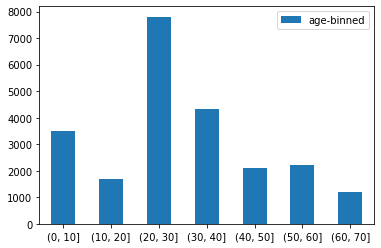

In [146]:
# Create bins
bins = [0, 10, 20, 30, 40, 50, 60, 70]

df['age-binned'] = pd.cut(df['age'], bins)

# Print results
print('We see that the bins are not even.\n')
print(df['age-binned'].value_counts().sort_index(), '\n')

pd.DataFrame(df['age-binned'].value_counts()).sort_index().plot.bar(rot=0)

<br><br><br>
# Balance the data/dataframe

In [207]:
def balance_dataframe(df):
    df_copy = copy.deepcopy(df)
    
    # Extract all the value counts for the binned ages
    all_value_counts = df['age-binned'].value_counts().sort_index()
    
    # Get the lowest amount of images for a binned class
    minimal_amount = min(all_value_counts)
    print('The lowest binned class has {} images, because we would like to enhance training we choose limit each class to {} images.'.format(minimal_amount, minimal_amount))
    
    # Loop overall the indexes and remove 
    final_df = pd.DataFrame()
    
    for index in all_value_counts.index:
        df_limited = df_copy[df_copy['age-binned'] == index][:minimal_amount]
        final_df   = final_df.append(df_limited)
    
    # Reset indexes
    final_df = final_df.reset_index()
    
    return final_df

In [208]:
df = balance_dataframe(df)

The lowest binned class has 1183 images, because we would like to enhance training we choose limit each class to 1183 images.


We see that the bins are even.

(0, 10]     1183
(10, 20]    1183
(20, 30]    1183
(30, 40]    1183
(40, 50]    1183
(50, 60]    1183
(60, 70]    1183
Name: age-binned, dtype: int64 



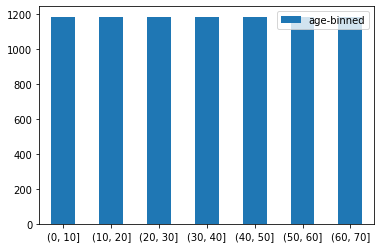

In [210]:
# Print results
print('We see that the bins are even.\n')
print(df['age-binned'].value_counts().sort_index(), '\n')

pd.DataFrame(df['age-binned'].value_counts()).sort_index().plot.bar(rot=0)

In [211]:
# Pickle the result
with open('df.pkl', 'wb') as output_file:
    pickle.dump(df, output_file)

In [212]:
# Open saved pickle file and test the saved df.
with open('df.pkl', 'rb') as input_file:
    df = pickle.load(input_file)

display(df.shape)
df.head()

(8281, 7)

,index,age,gender,race,datetime,path,age-binned
0,4,10,0,0,20161220222308131,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild\part1\10_0_0_20161220222308131.jpg,"(0, 10]"
1,5,10,0,0,20170103200329407,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild\part1\10_0_0_20170103200329407.jpg,"(0, 10]"
2,6,10,0,0,20170103200522151,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild\part1\10_0_0_20170103200522151.jpg,"(0, 10]"
3,7,10,0,0,20170103233459275,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild\part1\10_0_0_20170103233459275.jpg,"(0, 10]"
4,8,10,0,0,20170104013211746,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild\part1\10_0_0_20170104013211746.jpg,"(0, 10]"


<br><br><br>
# Create new folder structure

In [213]:
%%time

# Create folders for training, validation and testing
TRAINING_VALIDATION_TESTING_FOLDERS = ['training', 'validation', 'test']
TRAINING_VALIDATION_TESTING_FOLDERS = [os.path.join(new_directory, folder) for folder in TRAINING_VALIDATION_TESTING_FOLDERS]


# Creating all categories as folders
for new_folder in TRAINING_VALIDATION_TESTING_FOLDERS:
    try:
        os.mkdir(new_folder)
    except OSError:
        print ("Creation of the directory %s failed    \n\n" % new_folder)
    else:
        print ("Successfully created the directory %s  \n\n" % new_folder)

Successfully created the directory D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild-new-structure-balanced\training  


Successfully created the directory D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild-new-structure-balanced\validation  


Successfully created the directory D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild-new-structure-balanced\test  


Wall time: 2 ms


In [214]:
%%time

# Creating all categories as folders
CATEGORIES = bins[1:] # we dont include 0
TRAINING_CATEGORIES = [os.path.join(TRAINING_VALIDATION_TESTING_FOLDERS[0], str(CATEGORY)) for CATEGORY in CATEGORIES]
VALIDATION_CATEGORIES = [os.path.join(TRAINING_VALIDATION_TESTING_FOLDERS[1], str(CATEGORY)) for CATEGORY in CATEGORIES]
TEST_CATEGORIES = [os.path.join(TRAINING_VALIDATION_TESTING_FOLDERS[2], str(CATEGORY)) for CATEGORY in CATEGORIES]


for new_folder in TRAINING_CATEGORIES:
    try:
        os.mkdir(new_folder)
    except OSError:
        print("Creation of the directory %s failed    \n\n" % new_folder)

print('Finished with TRAINING_CATEGORIES')



for new_folder in VALIDATION_CATEGORIES:
    try:
        os.mkdir(new_folder)
    except OSError:
        print("Creation of the directory %s failed    \n\n" % new_folder)

print('Finished with VALIDATION_CATEGORIES')



for new_folder in TEST_CATEGORIES:
    try:
        os.mkdir(new_folder)
    except OSError:
        print("Creation of the directory %s failed    \n\n" % new_folder)

print('Finished with TEST_CATEGORIES')

Finished with TRAINING_CATEGORIES
Finished with VALIDATION_CATEGORIES
Finished with TEST_CATEGORIES
Wall time: 6 ms


In [215]:
df

,index,age,gender,race,datetime,path,age-binned
0,4,10,0,0,20161220222308131,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild\part1\10_0_0_20161220222308131.jpg,"(0, 10]"
1,5,10,0,0,20170103200329407,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild\part1\10_0_0_20170103200329407.jpg,"(0, 10]"
2,6,10,0,0,20170103200522151,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild\part1\10_0_0_20170103200522151.jpg,"(0, 10]"
3,7,10,0,0,20170103233459275,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild\part1\10_0_0_20170103233459275.jpg,"(0, 10]"
4,8,10,0,0,20170104013211746,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild\part1\10_0_0_20170104013211746.jpg,"(0, 10]"
...,...,...,...,...,...,...,...
8276,23897,70,1,0,20170120223657854,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild\part3\70_1_0_20170120223657854.jpg,"(60, 70]"
8277,23898,70,1,1,20170119205140215,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild\part3\70_1_1_20170119205140215.jpg,"(60, 70]"
8278,23899,70,1,1,20170120222723433,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild\part3\70_1_1_20170120222723433.jpg,"(60, 70]"
8279,23900,70,1,1,20170120223544080,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild\part3\70_1_1_20170120223544080.jpg,"(60, 70]"


<br><br><br>
# Split data

In [228]:
# Random state that will be used to 'randomly' split the data into training, validation and test.
np.random.seed(1)

# Split the dataframe into train, validation and test
probs = np.random.rand(len(df))
training_mask = probs < 0.75
validation_mask = (probs>=0.75) & (probs < 0.95)
test_mask  = probs >= 0.95


df_training = df[training_mask]
df_validation = df[validation_mask]
df_test = df[test_mask]

print('Length training:   ', len(df_training))
print('Length validation: ', len(df_validation))
print('Length test:       ', len(df_test))

Length training:    6243
Length validation:  1646
Length test:        392


In [229]:
# Check if the splitting up the dataframe was done correctly (if yes, then both df have one or more overlapping rows)
print('Overlapping paths in training and validation? Answer: ', bool(set(df_training['path']) & set(df_validation['path'])))
print('Overlapping paths in training and test? Answer:       ', bool(set(df_training['path']) & set(df_test['path'])))
print('Overlapping paths in validation and test? Answer:     ', bool(set(df_validation['path']) & set(df_test['path'])))

Overlapping paths in training and validation? Answer:  False
Overlapping paths in training and test? Answer:        False
Overlapping paths in validation and test? Answer:      False


df training binned ages distribution


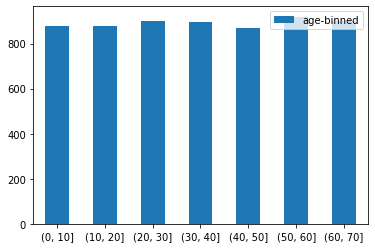

In [231]:
print('df_training binned ages distribution')
pd.DataFrame(df_training['age-binned'].value_counts()).sort_index().plot.bar(rot=0)

df_validation binned ages distribution


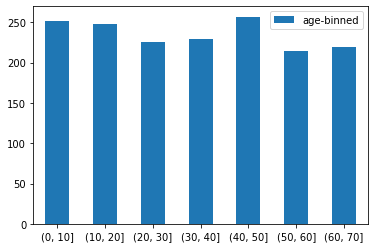

In [232]:
print('df_validation binned ages distribution')
pd.DataFrame(df_validation['age-binned'].value_counts()).sort_index().plot.bar(rot=0)

df_test binned ages distribution


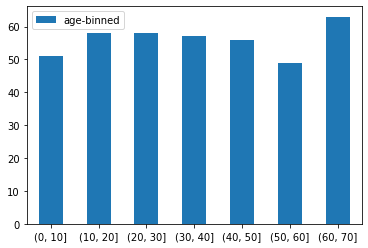

In [233]:
print('df_test binned ages distribution')
pd.DataFrame(df_test['age-binned'].value_counts()).sort_index().plot.bar(rot=0)

<br><br><br>
# Move images

In [234]:
def check_interval(x, intervals=df['age-binned'].unique()):
    if x in intervals[0]:
        return str(10)
    
    elif x in intervals[1]:
        return str(20)
    
    elif x in intervals[2]:
        return str(30)
    
    elif x in intervals[3]:
        return str(40)
    
    elif x in intervals[4]:
        return str(50)
    
    elif x in intervals[5]:
        return str(60)
    
    elif x in intervals[6]:
        return str(70)

In [235]:
TRAINING_PATH   = TRAINING_VALIDATION_TESTING_FOLDERS[0]
VALIDATION_PATH = TRAINING_VALIDATION_TESTING_FOLDERS[1]
TEST_PATH       = TRAINING_VALIDATION_TESTING_FOLDERS[2]

df_training['new-path']   = df_training['age'].apply(lambda x: os.path.join(TRAINING_PATH, check_interval(x)))
df_validation['new-path'] = df_validation['age'].apply(lambda x: os.path.join(VALIDATION_PATH, check_interval(x)))
df_test['new-path']       = df_test['age'].apply(lambda x: os.path.join(TEST_PATH, check_interval(x)))

C:\Users\Paulo\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Paulo\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Paulo\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [236]:
# Combine the results to one dataframe
def correct_category(path):
    if 'training' in path:
        return 'training'
    
    elif 'validation' in path:
        return 'validation'
    
    elif 'test' in path:
        return 'test'
    
    else:
        return None
    
df = df_training.append(df_validation).append(df_test).sort_index()
df['category'] = df['new-path'].apply(lambda x: correct_category(x))
df['path'] = df['new-path']
df = df.drop(['new-path'], axis=1)
df = df[['age', 'age-binned', 'gender', 'race', 'datetime', 'category', 'path']]

display(df.head())


# Pickle the result
with open('df.pkl', 'wb') as output_file:
    pickle.dump(df, output_file)

,age,age-binned,gender,race,datetime,category,path
0,10,"(0, 10]",0,0,20161220222308131,training,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild-new-structure-balanced\training\10
1,10,"(0, 10]",0,0,20170103200329407,training,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild-new-structure-balanced\training\10
2,10,"(0, 10]",0,0,20170103200522151,training,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild-new-structure-balanced\training\10
3,10,"(0, 10]",0,0,20170103233459275,training,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild-new-structure-balanced\training\10
4,10,"(0, 10]",0,0,20170104013211746,training,D:\Datamap Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_inthewild-new-structure-balanced\training\10


In [237]:
%%time 

# Move all the newly defined trainings data
for index, row in df_training.iterrows():
    shutil.copy(row['path'], row['new-path'])
    
# Move all the newly defined validation data
for index, row in df_validation.iterrows():
    shutil.copy(row['path'], row['new-path'])

# Move all the newly defined test data
for index, row in df_test.iterrows():
    shutil.copy(row['path'], row['new-path'])

Wall time: 15.7 s


In [238]:
# Extract all the files of our dataset folder. This folder contains 3 subfolders
# with each containing parts of our dataset.
all_files = extract_all_files(new_directory)
print('Lenght of the collected files from our path is: ', len(all_files))

Lenght of the collected files from our path is:  8281
